Optimal threshold from valid ROC: 0.308
[Retrain 1/20] loss=0.6883
[Retrain 2/20] loss=0.6300
[Retrain 3/20] loss=0.5640
[Retrain 4/20] loss=0.5277
[Retrain 5/20] loss=0.4876
[Retrain 6/20] loss=0.4585
[Retrain 7/20] loss=0.4338
[Retrain 8/20] loss=0.4055
[Retrain 9/20] loss=0.3774
[Retrain 10/20] loss=0.3571
[Retrain 11/20] loss=0.3281
[Retrain 12/20] loss=0.3107
[Retrain 13/20] loss=0.2955
[Retrain 14/20] loss=0.2788
[Retrain 15/20] loss=0.2643
[Retrain 16/20] loss=0.2479
[Retrain 17/20] loss=0.2390
[Retrain 18/20] loss=0.2265
[Retrain 19/20] loss=0.2106
[Retrain 20/20] loss=0.2044

Test Acc @ thr=0.308: 0.4555
Test AUC: 0.3646
Confusion Matrix:
 [[  7 130]
 [ 23 121]]

Classification Report:
               precision    recall  f1-score   support

           0     0.2333    0.0511    0.0838       137
           1     0.4821    0.8403    0.6127       144

    accuracy                         0.4555       281
   macro avg     0.3577    0.4457    0.3482       281
weighted avg     0.3608

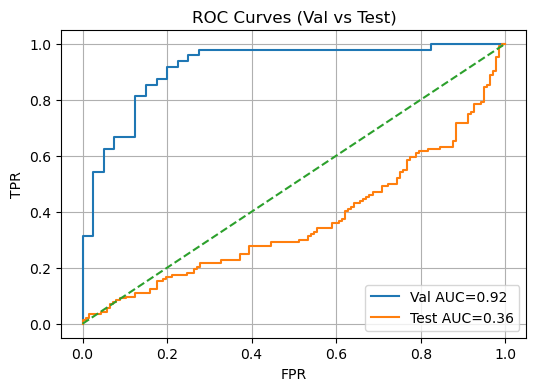

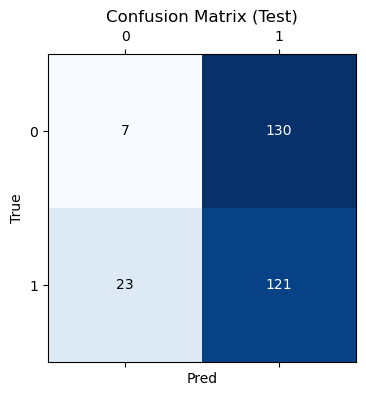

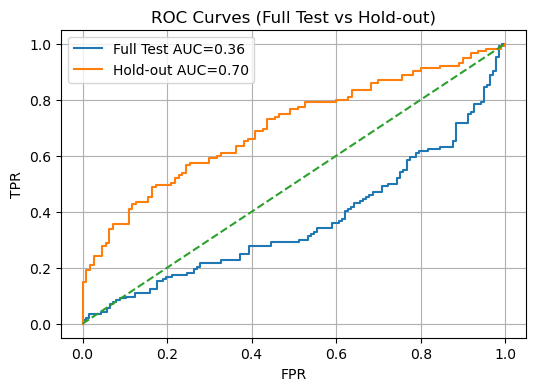

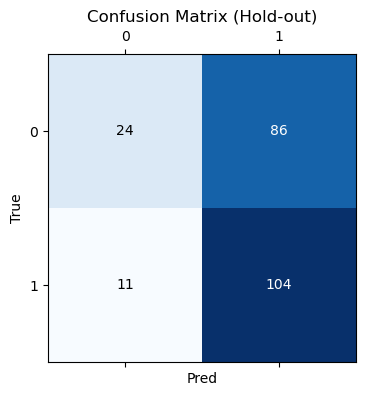

In [ ]:
# Jupyter Notebook용: Test 일부로 재학습(fine-tune) 및 이미지 저장까지 포함한 통합 스크립트

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path

# ────────────────────────────────────────────────────────
# 0. 설정
DATA_ROOT       = Path("embbeding_data")
AGG_METHOD      = "mean"
DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE      = 64
LR              = 1e-4
WEIGHT_DECAY    = 1e-4
RETRAIN_EPOCHS  = 20
EARLY_STOP      = 5       # fine-tune 조기종료 patience
TEST_FRACTION   = 0.5     # 테스트의 20%를 fine-tune에 사용
SAVE_DIR        = Path("fusion_images")
SAVE_DIR.mkdir(exist_ok=True)
# ────────────────────────────────────────────────────────

# ────────────────────────────────────────────────────────
# 1. Embedding & Label 로드 함수
def load_split(split, model):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    return emb, lbl

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":   return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":    return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":return arr.reshape(arr.shape[0], -1)
    raise ValueError

# TS / ST train-valid-test 전부 로드
X_ts_tr, y_tr = load_split("train",   "timesformer")
X_st_tr, _    = load_split("train",   "stgcnpp")
X_ts_va, y_va = load_split("valid",   "timesformer")
X_st_va, _    = load_split("valid",   "stgcnpp")
X_ts_te, y_te = load_split("test",    "timesformer")
X_st_te, _    = load_split("test",    "stgcnpp")

# ST 차원 평균 축소
X_st_tr = reduce_stgcn(X_st_tr)
X_st_va = reduce_stgcn(X_st_va)
X_st_te = reduce_stgcn(X_st_te)

# ────────────────────────────────────────────────────────
# 2. Valid에서 optimal threshold 계산 (간단 LR 이용)
# ─── 전처리: train-valid 합친 scaler를 이용
scaler = StandardScaler().fit(np.concatenate([X_ts_tr, X_st_tr], axis=1))
X_va_scaled = scaler.transform(np.concatenate([X_ts_va, X_st_va], axis=1))

# 로지스틱 회귀로 valid 예측 확률 얻기
X_tr_scaled = scaler.transform(np.concatenate([X_ts_tr, X_st_tr], axis=1))
lr = LogisticRegression(max_iter=1000).fit(X_tr_scaled, y_tr)
probs_va = lr.predict_proba(X_va_scaled)[:,1]

# ROC로 최적 threshold
fpr_va, tpr_va, ths_va = roc_curve(y_va, probs_va)
opt_idx = np.argmax(tpr_va - fpr_va)
opt_thr = ths_va[opt_idx]
print(f"Optimal threshold from valid ROC: {opt_thr:.3f}")

# ────────────────────────────────────────────────────────
# 3. Train+Valid 전체로 Head MLP 재학습
# ─── Train+Valid 결합
X_trva = np.concatenate([
    np.concatenate([X_ts_tr, X_ts_va], axis=0),
    np.concatenate([X_st_tr, X_st_va], axis=0)
], axis=1)
y_trva = np.concatenate([y_tr, y_va], axis=0)

# 스케일링
X_trva_scaled = scaler.transform(X_trva).astype(np.float32)
X_te_scaled   = scaler.transform(np.concatenate([X_ts_te, X_st_te], axis=1)).astype(np.float32)

# Head MLP 정의
class HeadMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    def forward(self, x): return self.net(x)

# 모델·옵티마이저·손실
model = HeadMLP(X_trva_scaled.shape[1]).to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
crit  = nn.CrossEntropyLoss()

# DataLoader
ds_trva = TensorDataset(
    torch.from_numpy(X_trva_scaled),
    torch.from_numpy(y_trva)
)
dl_trva = DataLoader(ds_trva, batch_size=BATCH_SIZE, shuffle=True)

# 학습
best_loss, patience = float('inf'), 0
for epoch in range(1, RETRAIN_EPOCHS+1):
    model.train()
    loss_accum = 0.0
    for xb, yb in dl_trva:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        out = model(xb)
        loss = crit(out, yb)
        loss.backward()
        opt.step()
        loss_accum += loss.item() * yb.size(0)
    avg_loss = loss_accum / len(ds_trva)
    print(f"[Retrain {epoch}/{RETRAIN_EPOCHS}] loss={avg_loss:.4f}")
    if avg_loss < best_loss:
        best_loss, patience = avg_loss, 0
        best_state = model.state_dict()
    else:
        patience += 1
        if patience >= EARLY_STOP:
            print("Early stopping retrain")
            break

model.load_state_dict(best_state)

# ────────────────────────────────────────────────────────
# 4. Test 전체 평가 (valid threshold 사용)
# ─── 기존 test split 전체로 평가
model.eval()
with torch.no_grad():
    xb = torch.from_numpy(X_te_scaled).to(DEVICE)
    out = model(xb)
    probs_te = torch.softmax(out,1)[:,1].cpu().numpy()
    preds_te = (probs_te > opt_thr).astype(int)

acc_te  = accuracy_score(y_te, preds_te)
auc_te  = auc(*roc_curve(y_te, probs_te)[:2])
cm_te   = confusion_matrix(y_te, preds_te)

print(f"\nTest Acc @ thr={opt_thr:.3f}: {acc_te:.4f}")
print(f"Test AUC: {auc_te:.4f}")
print("Confusion Matrix:\n", cm_te)
print("\nClassification Report:\n",
      classification_report(y_te, preds_te, digits=4))

# ────────────────────────────────────────────────────────
# 5. Test 일부 가져와 fine-tune 후 나머지 평가
X_te_ft, X_te_hold, y_te_ft, y_te_hold = train_test_split(
    X_te_scaled, y_te, test_size=1-TEST_FRACTION,
    stratify=y_te, random_state=42
)

# Combine for fine-tune
X_ft_tr = np.vstack([X_trva_scaled, X_te_ft])
y_ft_tr = np.concatenate([y_trva, y_te_ft])

# re-init model
model_ft = HeadMLP(X_ft_tr.shape[1]).to(DEVICE)
opt_ft   = torch.optim.AdamW(model_ft.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
best_loss, patience = float('inf'), 0

ds_ft = TensorDataset(torch.from_numpy(X_ft_tr), torch.from_numpy(y_ft_tr))
dl_ft = DataLoader(ds_ft, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(1, RETRAIN_EPOCHS+1):
    model_ft.train()
    loss_accum = 0.0
    for xb, yb in dl_ft:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt_ft.zero_grad()
        out = model_ft(xb)
        loss = crit(out, yb)
        loss.backward()
        opt_ft.step()
        loss_accum += loss.item() * yb.size(0)
    avg_loss = loss_accum / len(ds_ft)
    if avg_loss < best_loss:
        best_loss, patience = avg_loss, 0
        best_state_ft = model_ft.state_dict()
    else:
        patience += 1
        if patience >= EARLY_STOP:
            break

model_ft.load_state_dict(best_state_ft)

# Evaluate on held-out portion
model_ft.eval()
with torch.no_grad():
    xb = torch.from_numpy(X_te_hold).to(DEVICE)
    out = model_ft(xb)
    probs_hold = torch.softmax(out,1)[:,1].cpu().numpy()
    preds_hold = (probs_hold > opt_thr).astype(int)

acc_hold = accuracy_score(y_te_hold, preds_hold)
auc_hold = auc(*roc_curve(y_te_hold, probs_hold)[:2])
cm_hold  = confusion_matrix(y_te_hold, preds_hold)

print(f"\nHold-out Acc @ thr={opt_thr:.3f}: {acc_hold:.4f}")
print(f"Hold-out AUC: {auc_hold:.4f}")
print("Hold-out Confusion Matrix:\n", cm_hold)
print("\nHold-out Report:\n",
      classification_report(y_te_hold, preds_hold, digits=4))

# ────────────────────────────────────────────────────────
# 6. 이미지 저장 (ROC & Confusion Matrix)
# ─── 전체 Test
fpr_te, tpr_te, _ = roc_curve(y_te, probs_te)
plt.figure(figsize=(6,4))
plt.plot(fpr_va, tpr_va, label=f"Val AUC={auc(fpr_va,tpr_va):.2f}")
plt.plot(fpr_te, tpr_te, label=f"Test AUC={auc_te:.2f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curves (Val vs Test)")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid()
plt.savefig(SAVE_DIR/"roc_val_test.png")
plt.show()

# ─── Test Confusion Matrix ───────────────────────────────
fig, ax = plt.subplots(figsize=(4,4))
cax = ax.matshow(cm_te, cmap="Blues")
for (i, j), v in np.ndenumerate(cm_te):
    ax.text(j, i, str(v), ha='center', va='center', color='white' if v>cm_te.max()/2 else 'black')
ax.set_xlabel("Pred")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Test)")
fig.savefig(SAVE_DIR/"confusion_test.png")
plt.show()
plt.close(fig)

# ────────────────────────────────────────────────────────
# ─── Hold-out 후 fine-tune 결과
fpr_h, tpr_h, _ = roc_curve(y_te_hold, probs_hold)
plt.figure(figsize=(6,4))
plt.plot(fpr_te, tpr_te, label=f"Full Test AUC={auc_te:.2f}")
plt.plot(fpr_h,  tpr_h,  label=f"Hold-out AUC={auc_hold:.2f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curves (Full Test vs Hold-out)")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid()
plt.savefig(SAVE_DIR/"roc_full_holdout.png")
plt.show()

# ─── Hold-out Confusion Matrix ───────────────────────────
fig, ax = plt.subplots(figsize=(4,4))
cax = ax.matshow(cm_hold, cmap="Blues")
for (i, j), v in np.ndenumerate(cm_hold):
    ax.text(j, i, str(v), ha='center', va='center', color='white' if v>cm_hold.max()/2 else 'black')
ax.set_xlabel("Pred")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Hold-out)")
fig.savefig(SAVE_DIR/"confusion_holdout.png")
plt.show()
plt.close(fig)
